<h2><center>ML take home exercice</h2>

<h3>DESCRIPTION : </h3>

Imagine I am a client of Lynceus and I have wafers that pass a visual inspection, after the inspection they are classified in a few categories. At the moment there is a person doing the inspection, but I would like to automate the process. For this reason, I am sending you a dataset collected during the last month of production: there are pictures of the wafers and their classification.

- Could you tell me if it is possible to automate the test and with what accuracy?

- Could you show me what results you obtained?

- Could you propose strategies to improve the result and give an estimate of how much you expect the results to improve?

Since we already have a dataset of wafers images and their labels, we can consider the possibility of building a prediction model to automate the test.

In [607]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
# import  pickle
# import joblib

<h4><center>========{ Data exploration }========</h4>

<h5>Data loading</h5> 

To load the data I used pandas module. 

In [608]:
PATH_DATASET = './data/waferImg26x26.pkl'

df = pd.read_pickle(PATH_DATASET)
images = df.images.values
for i in range(len(images)) : 
    images[i] = images[i].T

labels = df.labels.values
labels = np.asarray([str(l[0]) for l in labels])
labels[labels=='none'] = 'normal'

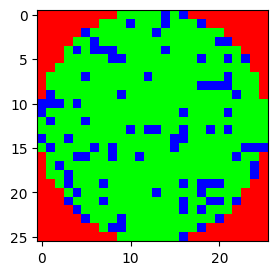

In [609]:
plt.figure(figsize=(3, 3))
plt.imshow(images[0])
plt.show()

<h5>Classes distribution</h5>

In [610]:
classes = np.unique(labels)

y = np.zeros(len(labels))
for i in range(len(classes)):
    y[labels==classes[i]] = i

y = y.astype(int)

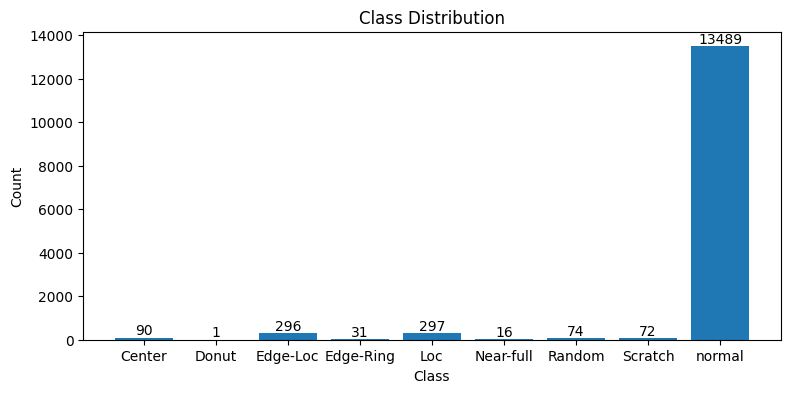

In [611]:
class_counts = np.bincount(y)

plt.figure(figsize=(9,4))

plt.bar(classes, class_counts)

for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

**Red flag** : the data is largely imbalanced, the class normal represents more than 93% of the whole dataset, and some classes like Donut and ner_full contains insufficient instances to train a certain model

<h5>Classes visualization</h5>

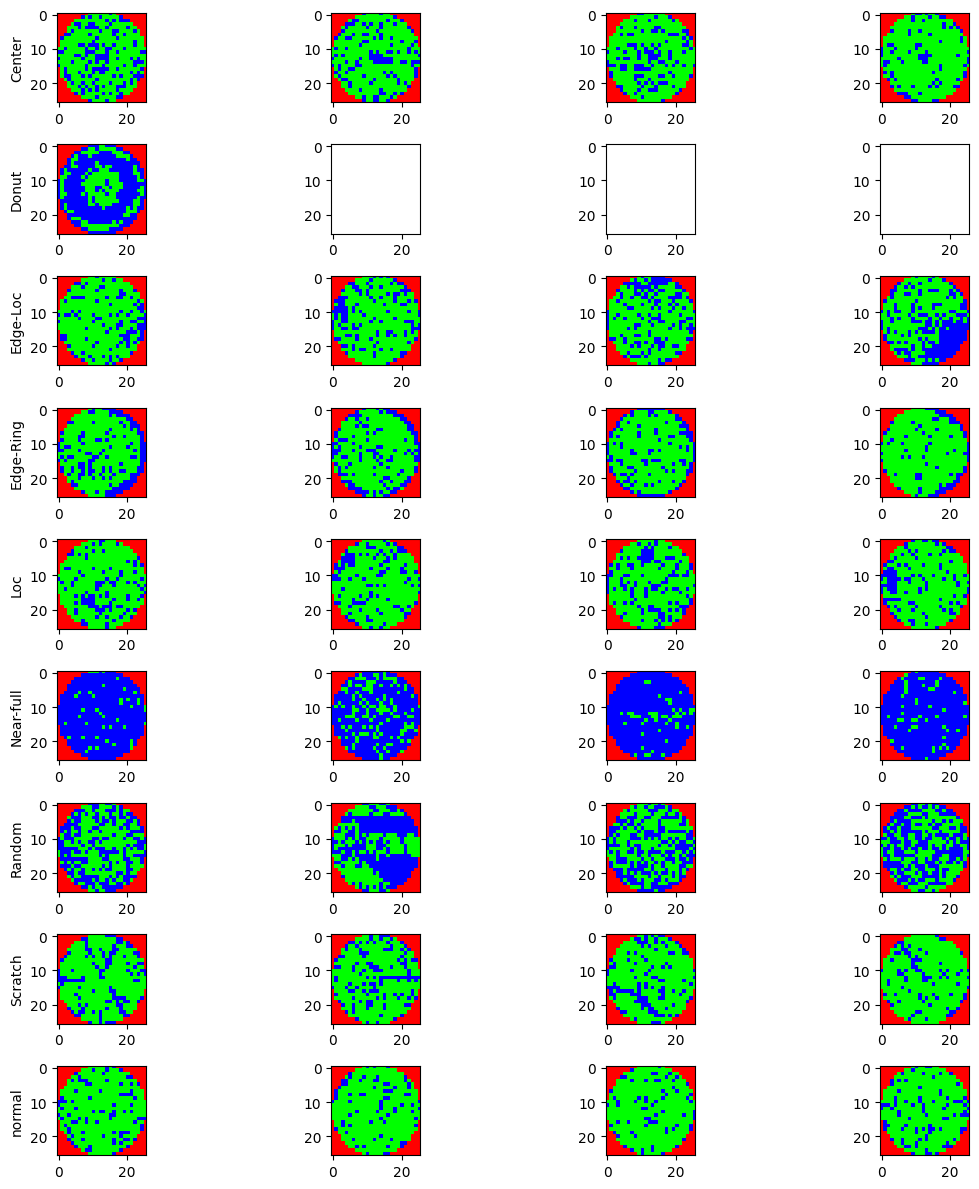

In [612]:
# Create subplots in a 4x4 grid
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(12, 12))

# Plot data on each subplot using axes[i, j]
for i in range(9):
    for j in range(4):
        try : 
            axes[i, j].imshow(images[y==i][j])
            if j==0 : 
                axes[i, j].set_ylabel(classes[i])
        except : 
            axes[i, j].imshow(np.zeros((26, 26, 3))+1)

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
plt.show()

From this figure, I assume that the pixels represent the malfunctioning circuits or cells in the wafer and the classes represent the shape or the form of these defected cells.

<h5>Data analysis</h5>

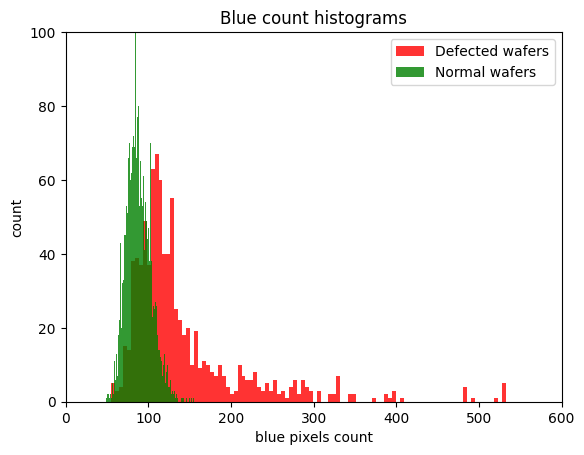

In [613]:
defected = images[labels!='normal']
blue_pixels_defected = [np.sum(defected[i][:, :, 2]) for i in range(len(defected))]

normal = images[labels=='normal'][:2500]
blue_pixels_normal = [np.sum(normal[i][:, :, 2]) for i in range(len(normal))]

fig, ax = plt.subplots()

ax.hist(blue_pixels_defected, bins=100, color='red', alpha=0.8, label='Defected wafers')
ax.hist(blue_pixels_normal, bins=100, color='green', alpha=0.8, label='Normal wafers')
ax.set_title('Blue count histograms')
ax.set_xlabel('blue pixels count')
ax.set_ylabel('count')
ax.set_xlim([0, 600])
ax.set_ylim([0, 100])

ax.legend()
plt.show()

Naturally, the normal wafers contain less defective cells than the other classes.

<h4><center>========{ Data augmentation }========</h4>

In order to solve the data imbalance problem, I decided to implement a data augmentation pipeline by rotating and flipping the images randomly to create new instances.

In [614]:
class DatasetBalancedAug(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        self.transform = transform
        self.X_train = None 
        self.X_test = None 
        self.y_train = None 
        self.y_test= None 
    
    def len_class(self, c, train=True):
        if train : 
            return np.sum(self.y_train==c)
        else : 
            return np.sum(self.y_test==c)

    def getitem(self, idx, c, train=True, trans=True):

        if train : 
            image = self.X_train[self.y_train==c][idx]
            label = self.y_train[self.y_train==c][idx]
        else : 
            image = self.X_test[self.y_test==c][idx]
            label = self.y_test[self.y_test==c][idx]

    
        if self.transform and trans:
            trans_image = self.transform(np.uint8(image))
            return {'image': trans_image, 'label': label}
        else : 
            return {'image': np.uint8(image), 'label': label}
    
    def fair_split(self, prop=0.2):
        for c in self.classes : 
            n = int(1/prop) + 1 
            if np.sum(self.y==c) < n : 
                for _ in range(n-np.sum(self.y==c)) : 
                    self.X = np.concatenate((self.X, self.X[np.where(self.y==c)[0][:1]]))
                    self.y = np.concatenate((self.y, [c]))

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=prop, random_state=42, stratify=self.y, shuffle=True)

    def augment(self, nb_class, train=True, trans=True): 
        self.fair_split(0.2)
        X_aug, y_aug = [], []
        pos = 0
        for i in range(len(self.classes)) : 
            l = self.len_class(self.classes[i], train=train)
            quot, rem = nb_class//l, nb_class%l
            if trans : 
                for _ in range(quot) :
                    for k in range(l) : 
                        sampled_img = self.getitem(k, self.classes[i], train=train, trans=trans)
                        X_aug.append(np.array(sampled_img['image']).astype('float32'))
                        X_aug[pos][:, :, 0] = 0*X_aug[pos][:, :, 0]
                        y_aug.append(sampled_img['label']) 
                        pos += 1
                for k in range(rem) : 
                        sampled_img = self.getitem(k, self.classes[i], train=train, trans=trans)
                        X_aug.append(np.array(sampled_img['image']).astype('float32'))
                        X_aug[pos][:, :, 0] = 0*X_aug[pos][:, :, 0]
                        y_aug.append(sampled_img['label']) 
                        pos += 1
            else : 
                for k in range(l) : 
                        
                        if k<nb_class : 
                            sampled_img = self.getitem(k, self.classes[i], train=train, trans=trans)
                            X_aug.append(np.array(sampled_img['image']).astype('float32'))
                            X_aug[pos][:, :, 0] = 0*X_aug[pos][:, :, 0]
                            y_aug.append(sampled_img['label']) 
                            pos += 1
                        else : 
                            print(k)
                            break
        
        return np.array(X_aug), np.array(y_aug).astype(int)




# Define your data augmentation pipeline
data_transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomRotation(degrees=60),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

custom_dataset = DatasetBalancedAug(images, y, transform=data_transform)
X_aug_train, y_aug_train = custom_dataset.augment(700, train=True, trans=True)
X_non_aug_train, y_non_aug_train = custom_dataset.augment(300, train=True, trans=False)
X_aug_test, y_aug_test = custom_dataset.augment(100, train=False, trans=True)

300


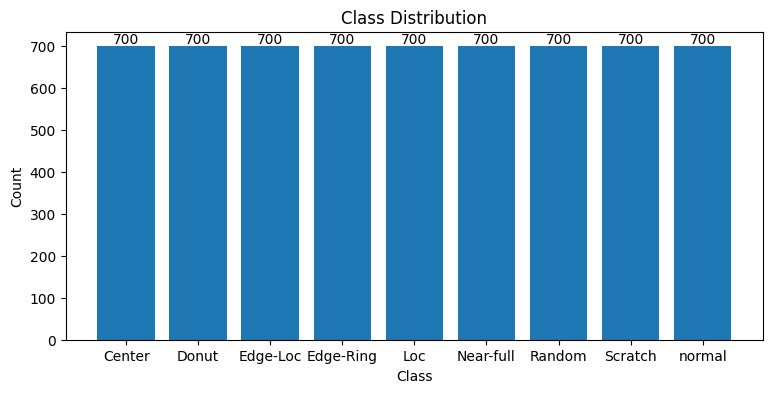

In [615]:
class_counts = np.bincount(y_aug_train.astype(int))

plt.figure(figsize=(9,4))

plt.bar(classes, class_counts)

for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

Now we have a balanced dataset where each class is equally represented

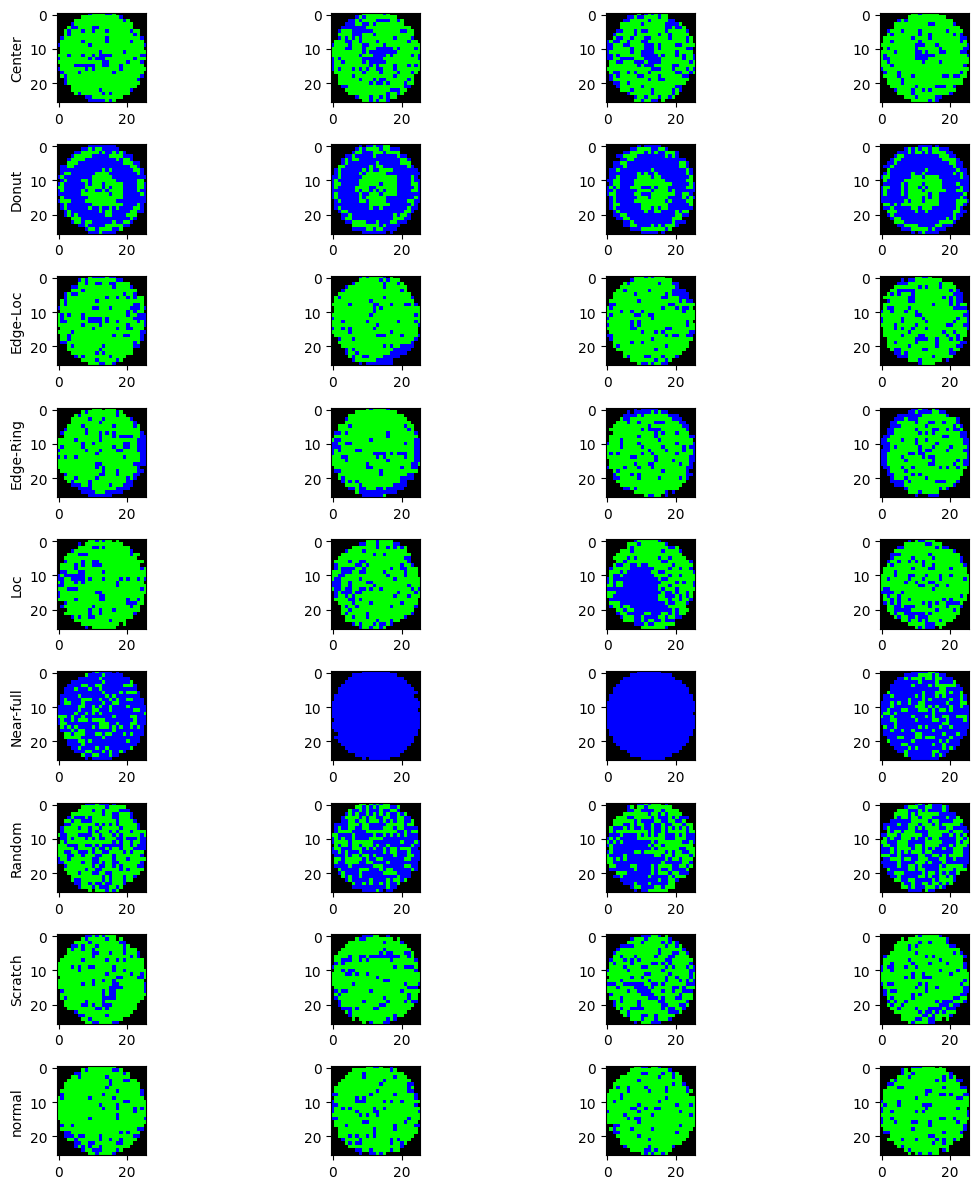

In [616]:
# Create subplots in a 4x4 grid
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(12, 12))

# Plot data on each subplot using axes[i, j]
for i in range(9):
    for j in range(4):
        try : 
            axes[i, j].imshow((X_aug_train[y_aug_train==i][j]))
            if j==0 : 
                axes[i, j].set_ylabel(classes[i])
        except : 
            axes[i, j].imshow(np.zeros((26, 26, 3))+1)


plt.tight_layout()

# Show the plot
plt.show()

This figure was displayed just to ensure that patterns are still clear even after the transformations. Because of the low resolution of the images, the patterns change slightly when rotating (which is good to create uncorrelated instances and improve the training of our model).

<h4><center>========{ First simple model : Random forest }========</h4>

To start, I tried solving the problem with a simple model like random forests, this model does not take into account the patterns like deep learning models, but it will constitute our first naive model to compare with.

In [617]:
X_aug_train_flatten = np.zeros((X_aug_train.shape[0], X_aug_train.shape[1]*X_aug_train.shape[2]*X_aug_train.shape[3]))

for i in range(len(X_aug_train)) : 
    X_aug_train_flatten[i] = np.array(X_aug_train[i]).flatten()

X_aug_train_flatten.shape

(6300, 2028)

In [618]:
X_aug_test_flatten = np.zeros((X_aug_test.shape[0], X_aug_test.shape[1]*X_aug_test.shape[2]*X_aug_test.shape[3]))

for i in range(len(X_aug_test)) : 
    X_aug_test_flatten[i] = np.array(X_aug_test[i]).flatten()

X_aug_test_flatten.shape

(900, 2028)

<h5>Dimentionnality Reduction</h5>

Before training the RF, I first started with a dimensionality reduction, using PCA, to reduce the data shape from 26*26*3 to 6 so that the RF doesn't overfit.

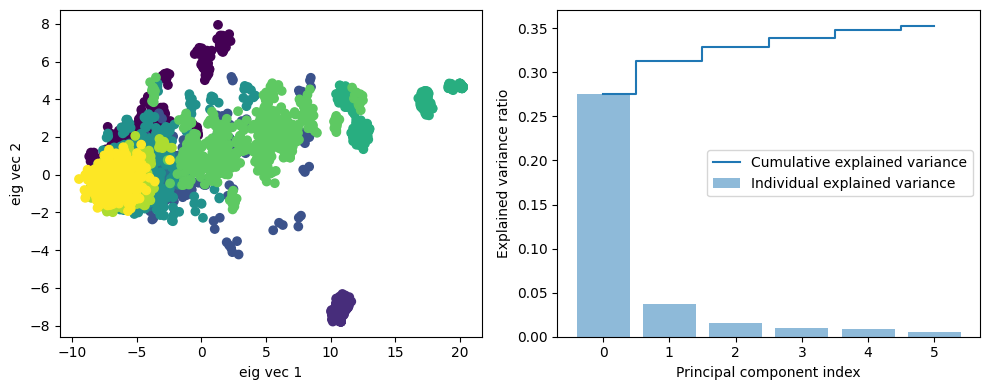

In [619]:
pca = PCA(n_components=6)
X_pca_train = pca.fit_transform(X_aug_train_flatten)
X_pca_test = pca.transform(X_aug_test_flatten)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_aug_train)
axes[0].set_xlabel('eig vec 1')
axes[0].set_ylabel('eig vec 2')


exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
axes[1].bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
axes[1].step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
axes[1].set_ylabel('Explained variance ratio')
axes[1].set_xlabel('Principal component index')
axes[1].legend(loc='best')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

<h5>Model construction</h5>

In [620]:
clf = RandomForestClassifier(max_depth=11, n_estimators=100, random_state=0)
clf.fit(X_pca_train, y_aug_train)

print('Test accuracy : ', clf.score(X_pca_test, y_aug_test))


y_pred = clf.predict(X_pca_test)

Test accuracy :  0.74


PS : the random forest performed better with dimensionality reduction than without.

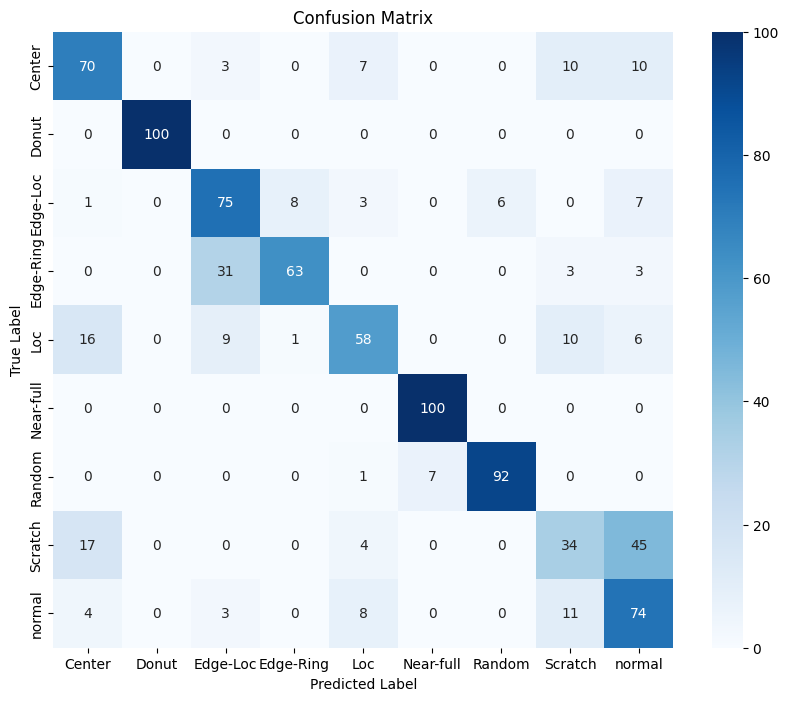

In [621]:
conf_matrix = confusion_matrix(y_aug_test, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

As predicted, this model will not give exceptional performance because it can't detect the different forms and clusters of defective cells in the image.

<h4><center>========{ Second model : CNN }========</h4>

<h5>Model construction</h5>

CNNs are known for their capacity to detect and recognize patterns in the images, so it would be more adequate to implement it as our next model. Because of the small size of our images and their simplicity, we won't need a big network, only a few layers will be sufficient.

In [622]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx].T
        label = self.y[idx]
        # image = torch.from_numpy(image)
        # label = torch.tensor(label)

        return image, label
    

train_dataset = MyDataset(X_aug_train, y_aug_train)
test_dataset = MyDataset(X_aug_test, y_aug_test)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# for inputs, labels in train_loader :
#     print(inputs.shape)

In [629]:


# Define the CNN model for (26, 26, 3) images
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        # self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.relu4 = nn.ReLU()
        # self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        # self.fc = nn.Linear(64 * 3 * 3, 9) 

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 64 * 3 * 3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(64 * 3 * 3, 9)
        )

    def forward(self, x):
        x = x.float()
        # print(x.shape)
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten before fully connected layer
        x = self.fc(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=576, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=576, out_features=9, bias=True)
  )
)


<h5>Model Training</h5>

In [630]:
# Training loop
num_epochs = 12
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/12, Loss: 0.6954443454742432
Epoch 2/12, Loss: 0.5436779856681824
Epoch 3/12, Loss: 0.6162423491477966
Epoch 4/12, Loss: 0.37263813614845276
Epoch 5/12, Loss: 0.4540201425552368
Epoch 6/12, Loss: 0.32086169719696045
Epoch 7/12, Loss: 0.3331230580806732
Epoch 8/12, Loss: 0.25305473804473877
Epoch 9/12, Loss: 0.20788785815238953
Epoch 10/12, Loss: 0.25954315066337585
Epoch 11/12, Loss: 0.16409526765346527
Epoch 12/12, Loss: 0.1519099622964859


<h5>Model Testing</h5>

In [631]:
# Testing loop
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []

miss_classified = dict()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += list(predicted)
        y_true += list(labels)
        for i in range(len(list(predicted))) :
            if predicted[i]!=labels[i] : 
                miss_classified[i] = {}
                miss_classified[i]['labels'] = (predicted)[i], (labels)[i]
                miss_classified[i]['out'] = np.array(outputs.data[i])
                miss_classified[i]['img'] = np.array(inputs[i]).astype(float)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 84.11%


PS : I tried to train the model with the augmented data, and without augmentation and sure enough the performance was enhanced by the data augmentation.

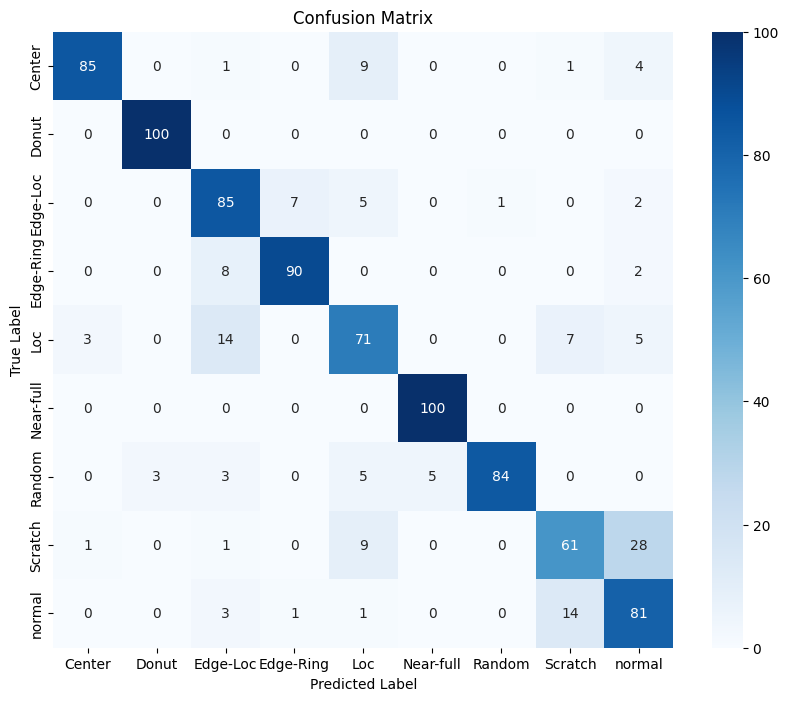

In [632]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The CNN is performing better than our first model (of course), but some classes are still confused with each other, which is understandable because an instance can be Loc and Edge Loc at the same time for example. Let's verify that our model gives in the output high scores for the classes that are similar which create the confusion.

<h5>Missclassified instances analysis</h5>

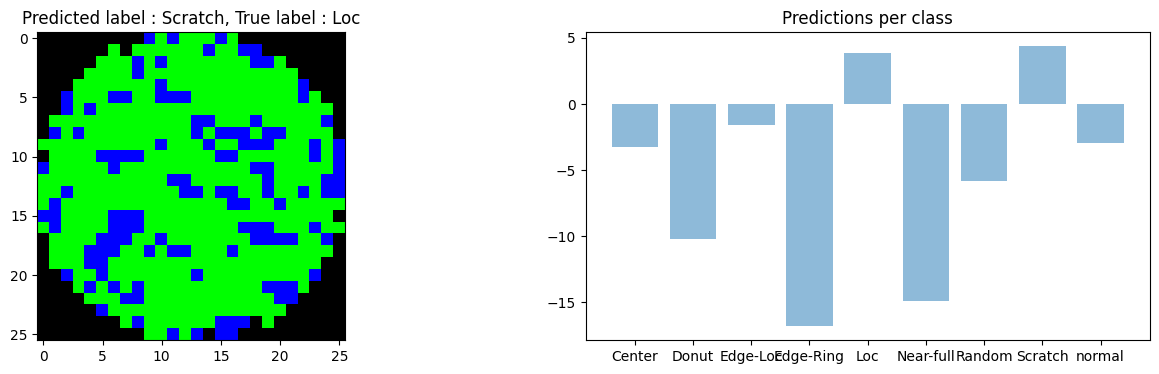

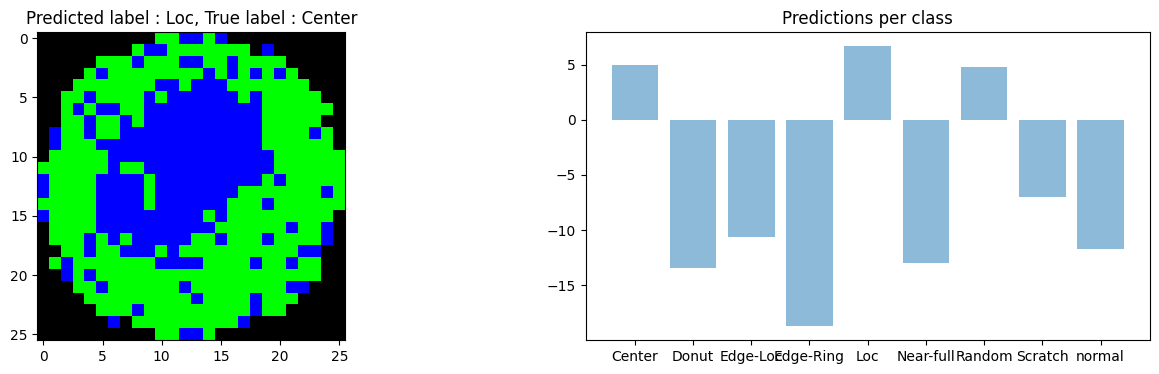

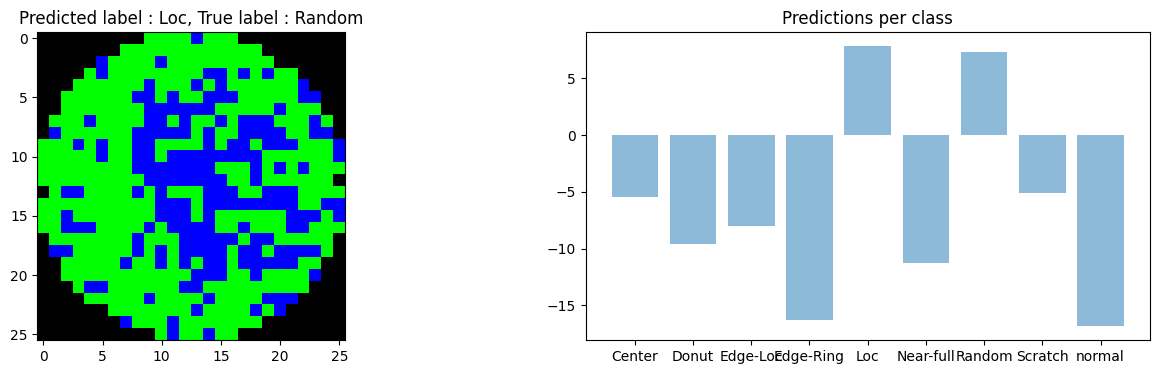

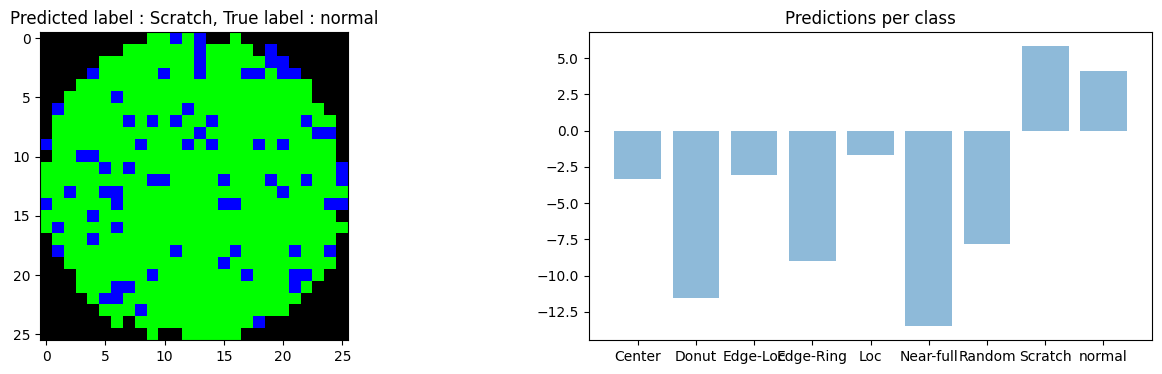

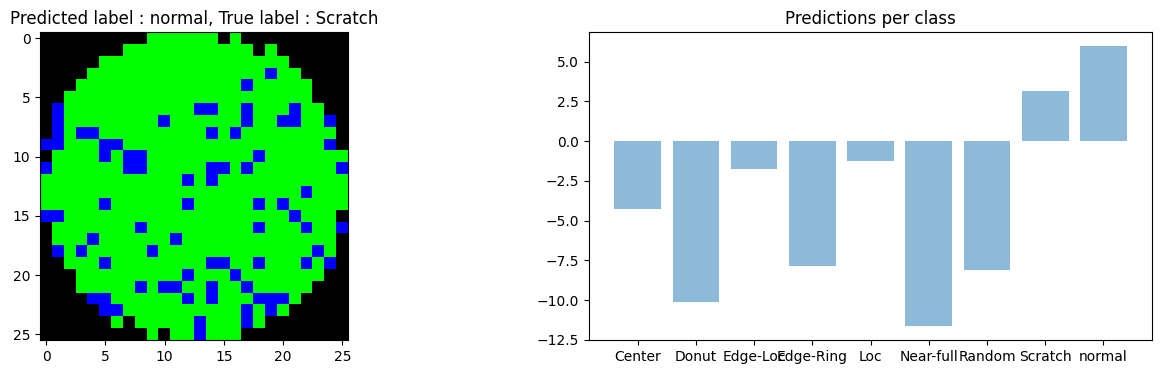

In [633]:
## Displaying few examples
num = 0
for i in miss_classified : 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    axes[0].imshow(miss_classified[i]['img'].T)
    p_l, t_l = classes[miss_classified[i]['labels'][0]], classes[miss_classified[i]['labels'][1]]
    axes[0].set_title(f'Predicted label : {p_l}, True label : {t_l}')
    axes[1].bar(classes, miss_classified[i]['out'], alpha=0.5, align='center')
    axes[1].set_title(f'Predictions per class')
    # print(miss_classified[i]['out'])
    plt.show()
    num +=1 
    if num==5 :
        break

As we can see in the first figure for example, the instance was classified as scratch but the true label was Loc, but we can see that the scores of the two classes were indeed close.

 
**To improve the results** :

1- We can try different architectures and variants of CNNs to find the one that performs the best on this dataset.

2- We can combine this CNN model with other simpler models to enhance the accuracy results (a sort of boosting).

3- We can analyse the classes that are confused, and infer some new features that can distinguish between those classes.

4- This suggestion is close to suggestion 2, but we can train other models to distinguish only between the classes that are close, for example a binary classification model that predicts Loc or Edge_loc and that are used when the big CNN model gives close scores to those to classes for example.  